# Data Augmentation Functions

Utilize albumentations library for augmentations


In [1]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.backends.cudnn.version())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


True
12.4
90100


In [2]:
%pip install --user albumentations


In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

def get_custom_transforms(
    flip=False,
    rotate=False,
    color_jitter=False,
    brightness_contrast=False,
    blur=False,
    crop_resize=False,
    normalize=False
):
    transform_list = []

    if flip:
        transform_list.append(A.HorizontalFlip(p=0.5))

    if rotate:
        transform_list.append(A.Rotate(limit=10, p=0.3))

    if color_jitter:
        transform_list.append(A.ColorJitter(
            brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5))

    if brightness_contrast:
        transform_list.append(A.RandomBrightnessContrast(p=0.3))

    if blur:
        transform_list.append(A.OneOf([
            A.MotionBlur(blur_limit=3),
            A.MedianBlur(blur_limit=3),
            A.GaussianBlur(blur_limit=3)
        ], p=0.3))

    if crop_resize:
        transform_list.extend([
            A.RandomCrop(width=384, height=384, p=0.3),
            A.Resize(512, 512)
        ])
    else:
        transform_list.append(A.Resize(512, 512))

    if normalize:
      transform_list.append(A.Normalize(
          mean=(0.485, 0.456, 0.406),
          std=(0.229, 0.224, 0.225)
      ))
    transform_list.append(ToTensorV2())

    return A.Compose(
        transform_list,
        bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'])
    )


In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import json

def visualize_augmented_sample_from_paths(image_path, json_path, transform, normalized):
    # Load image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Load boxesda
    with open(json_path, 'r') as f:
        ann = json.load(f)

    boxes, labels = [], []
    for obj in ann["objects"]:
        (x1, y1), (x2, y2) = obj["points"]["exterior"]
        boxes.append([x1, y1, x2, y2])
        labels.append(1)

    boxes = np.array(boxes, dtype=np.float32)
    labels = np.array(labels, dtype=np.int64)

    # Apply Albumentations transform
    transformed = transform(image=image, bboxes=boxes, labels=labels)
    aug_image = transformed['image'].permute(1, 2, 0).cpu().numpy()

    # if normalized:
    #     mean = np.array([0.485, 0.456, 0.406])
    #     std = np.array([0.229, 0.224, 0.225])
    #     aug_image = (aug_image * std) + mean
    # elif aug_image.max() > 1.0:
    #     aug_image = aug_image / 255.0

    aug_boxes = transformed['bboxes']

    # Draw boxes
    for box in aug_boxes:
        x1, y1, x2, y2 = map(int, box)
        cv2.rectangle(aug_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Plot
    plt.figure(figsize=(8, 8))
    plt.imshow(np.clip(aug_image, 0, 1))
    plt.title("Augmented Sample")
    plt.axis("off")
    plt.show()


In [6]:
# image_path = '/content/drive/MyDrive/APS360_Dumps/processed/test_output_img/positive_G0028545.jpg'
# json_path = '/content/drive/MyDrive/APS360_Dumps/processed/test_output_ann/positive_G0028545.jpg.json'
# transform = get_custom_transforms(normalize=True)

# visualize_augmented_sample_from_paths(image_path, json_path, transform, True)


# Import Modules

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np

## Import Dataset

In [8]:
import os
import json
import torch
from torch.utils.data import Dataset
import cv2
import numpy as np
from tqdm import tqdm

class PotholeDataset(Dataset):
    def __init__(self, root_dir, split="train", transform=None):
      self.split = split
      self.transform = transform
      self.samples = []

      self.img_dir = os.path.join(root_dir, split, "img")
      self.json_dir = os.path.join(root_dir, split, "json")

      self.ignore_keywords = ["China_Drone", "China_MotorBike"]

      self.img_filenames = sorted(os.listdir(self.img_dir))
      total_files = len(self.img_filenames)
      print(f"[{split.upper()}] Total images: {total_files}")

      for fname in tqdm(self.img_filenames, desc=f"{split.upper()} loading"):
          if any(keyword in fname for keyword in self.ignore_keywords):
            print("Skipping invalid ones")
            continue

          img_path = os.path.join(self.img_dir, fname)
          json_path = os.path.join(self.json_dir, fname + ".json")

          if not os.path.exists(img_path):
              print(f"[SKIP] Missing image: {img_path}")
              continue

          if os.path.exists(json_path) and os.stat(json_path).st_size > 0:
              # Image with valid annotation
              self.samples.append(("with", fname))
          else:
              # Negative sample: no JSON or empty JSON
              self.samples.append(("without", fname))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
      category, filename = self.samples[idx]
      img_path = os.path.join(self.img_dir, filename)
      json_path = os.path.join(self.json_dir, filename + ".json")

      image = cv2.imread(img_path)
      if image is None:
          # print(f"[SKIP] Corrupted image during loading: {img_path}")
          return torch.zeros(3, 512, 512), torch.zeros((0, 4)), torch.zeros((0,), dtype=torch.int64)

      boxes = []
      labels = []

      if os.path.exists(json_path) and os.stat(json_path).st_size > 0:
          with open(json_path, "r") as f:
              try:
                  data = json.load(f)
              except json.JSONDecodeError:
                  print(f"[SKIP] Malformed JSON: {json_path}")
                  data = {}

          objects = data.get("objects", [])
          # print(f"🔍 {filename} -> {len(objects)} objects")

          for obj in objects:
              class_title = obj.get("classTitle", "")
              # print(f"   classTitle: {class_title}")
              if class_title == "pothole":
                  points = obj.get("points", {}).get("exterior", [])
                  # print(f"   points: {points}")
                  if len(points) == 2:
                      (x1, y1), (x2, y2) = points
                      boxes.append([x1, y1, x2, y2])
          labels = [1] * len(boxes)

      # else:
      #     print(f"[NO JSON or EMPTY] {json_path}")

      boxes = np.array(boxes, dtype=np.float32)
      labels = np.array(labels, dtype=np.int64)

      if self.transform:
          transformed = self.transform(image=image, bboxes=boxes, labels=labels)
          image = transformed['image']
          boxes = torch.tensor(transformed['bboxes'], dtype=torch.float32)
          labels = torch.tensor(transformed['labels'], dtype=torch.int64)
      else:
          image = torch.tensor(image).permute(2, 0, 1) / 255.0

      return image, boxes, labels



## Albumentations Transform

In [9]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.485, 0.456, 0.406),
                std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))


In [10]:
import os

root_dir = "/content/drive/MyDrive/APS360_Project/RDD_2022_ProcessedData"

for split in ["train", "val", "test"]:
    img_dir = os.path.join(root_dir, split, "img")
    json_dir = os.path.join(root_dir, split, "json")

    img_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.png'))]
    json_files = [f for f in os.listdir(json_dir) if f.endswith('.jpg.json') or f.endswith('.png.json')]

    print(f"[{split.upper()}]")
    print(f"  Images: {len(img_files)}")
    print(f"  JSONs:  {len(json_files)}\n")


[TRAIN]
  Images: 3031
  JSONs:  1484

[VAL]
  Images: 658
  JSONs:  331

[TEST]
  Images: 661
  JSONs:  325



## Load Dataset & DataLoader

In [11]:
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

training_dataset = PotholeDataset(
    root_dir="/content/drive/MyDrive/APS360_Project/RDD_2022_ProcessedData",
    split="train",
    transform=transform
)

valid_dataset = PotholeDataset(
    root_dir="/content/drive/MyDrive/APS360_Project/RDD_2022_ProcessedData",
    split="val",
    transform=transform
)

test_dataset = PotholeDataset(
    root_dir="/content/drive/MyDrive/APS360_Project/RDD_2022_ProcessedData",
    split="test",
    transform=transform
)


# for i in tqdm(range(len(training_dataset)), desc="Checking training dataset loading"):
#     image, boxes, labels = training_dataset[i]

[TRAIN] Total images: 3031


TRAIN loading:   0%|          | 0/3031 [00:00<?, ?it/s]

[VAL] Total images: 658


VAL loading:   0%|          | 0/658 [00:00<?, ?it/s]

[TEST] Total images: 661


TEST loading:   0%|          | 0/661 [00:00<?, ?it/s]

## For different batch sizes

In [12]:
# For variable-size boxes per image
def collate_fn(batch):
    images, boxes, labels = zip(*batch)
    images = torch.stack(images)
    return images, boxes, labels

train_DataLoader = DataLoader(training_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
val_DataLoader = DataLoader(valid_dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)
test_DataLoader = DataLoader(test_dataset, batch_size=4, shuffle=False, collate_fn=collate_fn)


## Sanity Check: Dataset

Found pothole at index: 1 with 1 pothole(s)


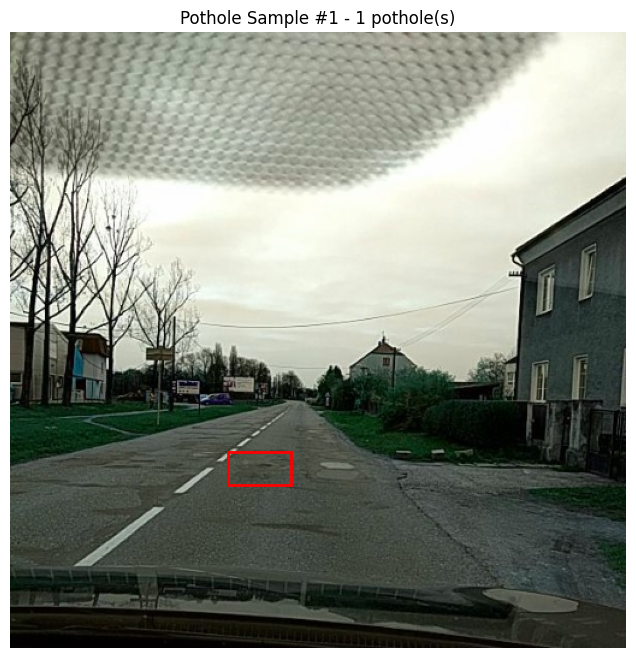

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import random
import matplotlib.patches as patches

# Utility to de-normalize a tensor image for display
def denormalize(img_tensor):
    mean = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    std = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)
    img = img_tensor.cpu().numpy()
    img = (img * std) + mean  # reverse normalization
    img = np.clip(img, 0, 1)  # clip to valid range
    return np.transpose(img, (1, 2, 0))  # CHW -> HWC for imshow

# Loop until we find an image with at least one pothole
for idx in range(len(training_dataset)):
    image, boxes, labels = training_dataset[idx]
    if len(boxes) > 0:
        print(f"Found pothole at index: {idx} with {len(boxes)} pothole(s)")

        # De-normalize for display
        image_np = denormalize(image)

        # Plot
        fig, ax = plt.subplots(1, figsize=(8, 8))
        ax.imshow(image_np)
        ax.set_title(f"Pothole Sample #{idx} - {len(boxes)} pothole(s)")

        for box in boxes:
            x1, y1, x2, y2 = box
            rect = patches.Rectangle(
                (x1, y1), x2 - x1, y2 - y1,
                linewidth=2, edgecolor='red', facecolor='none'
            )
            ax.add_patch(rect)

        plt.axis('off')
        plt.show()
        break



# Backbone Architecture: MobileNetv2


From the backbone, we extract 3 feature maps from MobileNetV2. These are to extract spatial and semantic features


Map 3: (B, 96, H3, W3) --> 1/8 resolution

Map 4: (B, 320, H4, W4) --> 1/16 resolution

Map 5: (B, 1280, H5, W5) --> 1/32 resolution

## Extract feature maps through backbone

In [69]:
class MobileNetBackbone(nn.Module):
    def __init__(self):
        super().__init__()
        mobilenet = torchvision.models.mobilenet_v2(weights="DEFAULT").features
        for param in mobilenet.parameters():
          param.requires_grad = False # Freeze features

        # Manually split based on layer structure of MobileNetV2
        self.stage1 = mobilenet[:4]    # → Output: [B, 32, 64, 64]
        self.stage2 = mobilenet[4:7]   # → Output: [B, 96, 32, 32]
        self.stage3 = mobilenet[7:]    # → Output: [B, 1280, 16, 16]

    def forward(self, x):
        x = self.stage1(x)
        fmap1 = x                      # fine features (1/8 scale)

        x = self.stage2(x)
        fmap2 = x                      # mid-level features (1/16 scale)

        x = self.stage3(x)
        fmap3 = x                      # coarse semantic features (1/32 scale)

        return [fmap1, fmap2, fmap3]


# Anchor Configurations

## How does anchor work?

We by default, place some fixed anchor boxes on the image.

When the model sees an actual object nearby, rather than returning the raw ground truth box, it learns to predict how to nudge this anchor to fit the real object.

In [15]:
scales = [0.1, 0.2, 0.3]
ratios = [1.0, 2.0, 0.5]
image_size = 512

In [16]:
def generate_anchors(feature_map_size, stride, scales, ratios, image_size=512):
  anchors = []
  fm_h, fm_w = feature_map_size

  for i in range(fm_h):
    for j in range(fm_w):
      cx = (j + 0.5) * stride
      cy = (i + 0.5) * stride

      for scale in scales:
        for ratio in ratios:
          w = image_size * scale * np.sqrt(ratio)
          h = image_size * scale / np.sqrt(ratio)

          anchors.append([cx, cy, w, h])

  return torch.tensor(anchors)

# Detection Heads

The detection head module consists of two parallel convolutional branches.

First branch is for class prediction for every anchor box.

The second branch is for bounding box regression per anchor box

For every feature map, it predicts
- Class (B, AxC, H, W): Raw class scores per anchor

- BBox (B, Ax4, H, W): Offsets from anchors per anchor. This is how much the prefixed anchor boxes should be moved to try to fit the pothole.

### Class Prediction for every anchor box
This output tensor has the shape (B, A x C, H, W)

B = Batch Size

A = Number of anchors per spatial location

C = Number of object classes (Only 1 in this case for potholes)

### Bounding Box Regression for every anchor box

This output tesnor has the shape (B, A x 4, H, W)

In [17]:
# class DetectionHead(nn.Module):
#     def __init__(self, in_channels, num_anchors, num_classes):
#         super().__init__()
#         self.class_head = nn.Conv2d(
#             in_channels=in_channels,
#             out_channels=num_anchors * num_classes,
#             kernel_size=3,
#             padding=1,
#         )
#         self.bbox_head = nn.Conv2d(
#             in_channels=in_channels,
#             out_channels=num_anchors * 4,
#             kernel_size=3,
#             padding=1,
#         )

#     def forward(self, x):
#         class_out = self.class_head(x)
#         bbox_out = self.bbox_head(x)
#         return class_out, bbox_out


In [18]:
class DetectionHead(nn.Module):
    def __init__(self, in_channels, num_anchors, num_classes):
        super().__init__()
        self.shared_conv = nn.Conv2d(
            in_channels=in_channels,
            out_channels=in_channels,
            kernel_size=3,
            padding=1
        )

        self.class_head = nn.Conv2d(
            in_channels=in_channels,
            out_channels=num_anchors * num_classes,
            kernel_size=1
        )

        self.bbox_head = nn.Conv2d(
            in_channels=in_channels,
            out_channels=num_anchors * 4,
            kernel_size=1
        )

    def forward(self, x):
        x = F.relu(self.shared_conv(x))
        class_out = self.class_head(x)  # (B, k, H, W)
        bbox_out = self.bbox_head(x)    # (B, 4k, H, W)
        return class_out, bbox_out


In [19]:
def rearrange_outputs(class_out, bbox_out, num_classes):
  # This rearranges outputs tensors

  # Classification goes to [B, N, C] [Batch Size, # of Anchors, Object Classes]
  # Regression goes to [B, N, 4]

  B, _, H, W = class_out.shape
  class_out = class_out.permute(0, 2, 3, 1).reshape(B, -1, num_classes)  # [B, N, C]
  bbox_out = bbox_out.permute(0, 2, 3, 1).reshape(B, -1, 4)          # [B, N, 4]
  return class_out, bbox_out

# Box Decoder

From the anchor generation and


The bounding box offsets follow the format [tx, ty, tw, th]

We need to obtain the final bounding box in image coordinates, utilizing these mathematical equations from the SSD paper.

$$x_{center} = t_x * w_a + x_a$$

$$y_{center} = t_y * h_a + y_a$$

$$w_{box} = exp(t_w) * w_a$$

$$h_{box} = exp(t_h) * h_a$$





In [20]:
import torch

def decode_boxes(pred_offsets, anchors):
  # Decodes predicted offsets back into bounding box coordinates into the corner format

  # For a given fixed anchor and predicted offsets, output the decoded bounding boxes in (x1, y1, x2, y2) format in shape [N, 4]
  variances = [0.1, 0.2]

  anchor_cx, anchor_cy, anchor_w, anchor_h = anchors[:, 0], anchors[:, 1], anchors[:, 2], anchors[:, 3]
  tx, ty, tw, th = pred_offsets[:, 0], pred_offsets[:, 1], pred_offsets[:, 2], pred_offsets[:, 3]

  # print("The shape of anchor_w is ", anchor_w.shape)
  # print("The shape of tx is ", tx.shape)


  pred_cs = tx * anchor_w + anchor_cx
  pred_cy = ty * anchor_h + anchor_cy
  # pred_w = torch.exp(tw) * anchor_w
  # pred_h = torch.exp(th) * anchor_h
  pred_w  = torch.exp(tw * variances[1]) * anchor_w
  pred_h  = torch.exp(th * variances[1]) * anchor_h

  x1 = pred_cs - pred_w / 2
  y1 = pred_cy - pred_h / 2
  x2 = pred_cs + pred_w / 2
  y2 = pred_cy + pred_h / 2

  decoded_boxes = torch.stack([x1, y1, x2, y2], dim=1)
  return decoded_boxes

# Loss Function

The loss function

1. Match anchros to ground truth boxes (Based on IoU)

IoU: Intersection over Union

2. Compute losses
- Localization Loss
- Classification Loss (Focal Loss)


### Computing IoU


This function computes the IoU between two sets of boxes

**Input**: Anchor box and Ground Truth Box

Procedure: For every anchor box, it checks how much it overlaps with every ground truth box

**Output**: [N, M] matrix where iou[i, j] indicates how well anchor i matches ground truth j.

This is the pairwise IoU between each predicted anchor and ground truth box.

This IoU is used to assign anchors to the best matching ground truth target.

In [21]:
def compute_iou(boxes1, boxes2):
  area1 = (boxes1[:, 2] - boxes1[:, 0]).clamp(0) * (boxes1[:, 3] - boxes1[:, 1]).clamp(0)
  area2 = (boxes2[:, 2] - boxes2[:, 0]).clamp(0) * (boxes2[:, 3] - boxes2[:, 1]).clamp(0)

  lt = torch.max(boxes1[:, None, :2], boxes2[:, :2])  # [N, M, 2]
  rb = torch.min(boxes1[:, None, 2:], boxes2[:, 2:])  # [N, M, 2]
  wh = (rb - lt).clamp(min=0)
  inter = wh[:, :, 0] * wh[:, :, 1]

  union = area1[:, None] + area2 - inter
  iou = inter / (union + 1e-6)
  # print("IoU shape:", iou.shape)  # [N, M]
  return iou  # [N, M]

In [22]:
def convert_cxcy_to_xy(boxes):
    cx, cy, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]
    x1 = cx - w / 2
    y1 = cy - h / 2
    x2 = cx + w / 2
    y2 = cy + h / 2
    return torch.stack([x1, y1, x2, y2], dim=-1)


Since the model learns to predict offsets relative to fixed anchor boxes, it should convert ground truth boxes to offsets.

In [23]:
def encode_boxes(ground_truth_boxes, anchors, variances=(0.1, 0.2)):
    eps = 1e-6
    gt_cx = (ground_truth_boxes[:, 0] + ground_truth_boxes[:, 2]) / 2
    gt_cy = (ground_truth_boxes[:, 1] + ground_truth_boxes[:, 3]) / 2
    gt_w  = (ground_truth_boxes[:, 2] - ground_truth_boxes[:, 0]).clamp(min=eps)
    gt_h  = (ground_truth_boxes[:, 3] - ground_truth_boxes[:, 1]).clamp(min=eps)

    anc_cx, anc_cy, anc_w, anc_h = anchors[:, 0], anchors[:, 1], anchors[:, 2], anchors[:, 3]

    tx = ((gt_cx - anc_cx) / anc_w) / variances[0]
    ty = ((gt_cy - anc_cy) / anc_h) / variances[0]
    tw = torch.log((gt_w / anc_w).clamp(min=eps)) / variances[1]
    th = torch.log((gt_h / anc_h).clamp(min=eps)) / variances[1]

    return torch.stack([tx, ty, tw, th], dim=-1)


## Computing SSD Loss

This takes in all of the following information

- Predicted class logits
- Predicted offset values
- Anchor boxes
- Ground truth boxes
- Ground truth labels


Returns the total loss.

## Hard Negative Mining

The predefined anchor boxes will naturally introduce lots of negative anchors. This may skew the loss calculations, so the model will only select the highest classificaiton losses.

We only want to use the hardest background eaxmples during training.

We should compute classification loss for every negative anchor, and sort them by *how bad* the model is doing. We will select the top-k hardest negatives

In [55]:
def ssd_loss(pred_cls, pred_offsets, anchors, gt_boxes, gt_labels, iou_threshold=0.5, neg_ratio=3.0):
  device = pred_cls.device

  # Convert the prediction to bounding box corners
  # decoded_anchors = convert_cxcy_to_xy(anchors)
  # decoded_anchors = decode_boxes(pred_offsets, anchors.to(pred_offsets.device))

  decoded_anchors = convert_cxcy_to_xy(anchors.to(pred_offsets.device))

  if gt_boxes.numel() == 0:
      # No GT → all anchors are background
      labels = torch.zeros(pred_cls.shape[0], device=device)
      cls_loss = F.binary_cross_entropy_with_logits(pred_cls[:, 0], labels, reduction='none')

      # Hard negative mining: keep top k hardest negatives
      num_neg = int(neg_ratio * 1)  # 1 fake positive to avoid zero
      _, neg_idx = cls_loss.topk(min(num_neg, cls_loss.numel()))
      cls_loss_final = cls_loss[neg_idx].sum()

      return cls_loss_final, torch.tensor(0.0, device=device)  # no loc loss

  if gt_boxes.numel() > 0:
    areas = (gt_boxes[:, 2] - gt_boxes[:, 0]) * (gt_boxes[:, 3] - gt_boxes[:, 1])
    # print("GT Box Area Stats:", areas.min().item(), areas.max().item(), areas.mean().item())


  # Compute the ious for the anchor predictions
  ious = compute_iou(decoded_anchors, gt_boxes)
  best_gt_iou, best_gt_idx = ious.max(dim=1)

  # Positive Mask: This is where IoU >= threshold and therefore we classify the box.

  pos_mask = best_gt_iou >= iou_threshold
  # print(f"# Positive anchors matched: {pos_mask.sum().item()}")
  num_pos = pos_mask.sum().clamp(min=1)

  matched_gt_boxes = gt_boxes[best_gt_idx]
  target_offsets = encode_boxes(matched_gt_boxes, anchors.to(matched_gt_boxes.device))
  # if pos_mask.sum() > 0:
  #     print("Sample target offset:", target_offsets[pos_mask][0])
  # else:
  #     print("No positive anchors matched.")
  loc_loss = F.smooth_l1_loss(pred_offsets[pos_mask], target_offsets[pos_mask], reduction='sum')

  # Compute the Classification Loss
  labels = torch.zeros(pred_cls.size(0), dtype=torch.float, device=pred_cls.device)
 # Get [N]
  matched_labels = gt_labels[best_gt_idx]
  labels[pos_mask] = gt_labels[best_gt_idx[pos_mask]].float()
  # print("Label distribution:", labels.unique(return_counts=True))


  # This is a binary classification problem
  cls_loss = F.binary_cross_entropy_with_logits(pred_cls[:, 0], labels, reduction='none')

  # Hard Negative Mining
  neg_mask = ~pos_mask
  num_neg = (neg_ratio * num_pos).int()
  neg_loss = cls_loss[neg_mask]
  _, neg_idx = neg_loss.topk(min(num_neg.item(), neg_loss.numel()), largest=True)
  cls_loss_final = cls_loss[pos_mask].sum() + neg_loss[neg_idx].sum()



  # total_loss = (cls_loss_final + loc_loss) / num_pos
  # return total_loss

  cls_loss_final /= num_pos
  loc_loss /= num_pos


  return cls_loss_final, loc_loss

## Postprocessing

For each image, we need to perform the following during inference time:
1. Decode bounding boxes from predicted offsets
2. Apply sigmoid to classificaiton scores
3. Filter out low-confidence scores below the threshold
4. Apply NMS to remove duplicates
5. Return final boxes + scores

### Non-Maximum Suppression (NMS)



Like how we removed duplicates in pre-processing, this is required in post-processing when the model does inferencing.

The output of the model is the following

pred_cls:    [N, 1]  ← sigmoid scores per anchor (objectness)

pred_boxes:  [N, 4]  ← decoded [x1, y1, x2, y2] box for each anchor

In [25]:
from torchvision.ops import nms

In [26]:
def postprocess(pred_cls_logits, pred_offsets, anchors, conf_threshold=0.2, nms_threshold=0.5, top_k=200):
    # Squeeze batch dim (if exists)
    if pred_cls_logits.dim() == 3:
        pred_cls_logits = pred_cls_logits.squeeze(0)  # [N, 1]
    if pred_offsets.dim() == 3:
        pred_offsets = pred_offsets.squeeze(0)
    if anchors.dim() == 3:
        anchors = anchors.squeeze(0)

    # Shape check
    assert pred_cls_logits.shape[0] == pred_offsets.shape[0] == anchors.shape[0], \
        f"Inconsistent shapes: cls={pred_cls_logits.shape}, offsets={pred_offsets.shape}, anchors={anchors.shape}"

    # Apply sigmoid and squeeze final class dim
    scores = torch.sigmoid(pred_cls_logits.squeeze(-1))  # [N]

    print("scores:", scores.shape)
    print("pred_offsets:", pred_offsets.shape)
    print("anchors:", anchors.shape)
    print(f"Score stats → min: {scores.min():.3f}, max: {scores.max():.3f}, mean: {scores.mean():.3f}")

    # Filter by confidence
    conf_mask = scores > conf_threshold
    print("conf_mask:", conf_mask.shape, "→ Num kept:", conf_mask.sum().item())

    if conf_mask.sum() == 0:
        return torch.empty((0, 4)), torch.empty((0,))

    scores = scores[conf_mask]
    filtered_offsets = pred_offsets[conf_mask]
    filtered_anchors = anchors[conf_mask]

    decoded_boxes = decode_boxes(filtered_offsets, filtered_anchors.to(filtered_offsets.device))

    # Apply NMS
    keep_idx = nms(decoded_boxes, scores, iou_threshold=nms_threshold)
    keep_idx = keep_idx[:top_k]

    final_boxes = decoded_boxes[keep_idx]
    final_scores = scores[keep_idx]

    return final_boxes, final_scores


# The SSD Architecture

In [27]:
class SSD(nn.Module):
  def __init__(self, backbone, detection_heads):
    super().__init__()
    self.backbone = backbone
    self.detection_heads = detection_heads

  def forward(self, x):
    # Step 1: Put image through backbone to extract features maps
    feature_maps = self.backbone(x)

    # print("Number of feature maps:", len(feature_maps))
    # for i, fmap in enumerate(feature_maps):
        # print(f"Feature map {i}: shape {fmap.shape}")


    all_cls_logits = []
    all_bbox_deltas = []

    for fmap, head in zip(feature_maps, self.detection_heads):
      cls_logits, bbox_deltas = head(fmap)

      # Batch Size
      B = cls_logits.shape[0]
      A = cls_logits.shape[1] // 1
      H, W = cls_logits.shape[2:]

      cls_logits = cls_logits.permute(0, 2, 3, 1).reshape(B, -1, 1)
      bbox_deltas = bbox_deltas.permute(0, 2, 3, 1).reshape(B, -1, 4)

      all_cls_logits.append(cls_logits)
      all_bbox_deltas.append(bbox_deltas)

    # final_cls_logits = torch.cat(all_cls_logits, dim=1).reshape(-1, 1)
    # final_bbox_deltas = torch.cat(all_bbox_deltas, dim=1).reshape(-1, 4)

    final_cls_logits = torch.cat(all_cls_logits, dim=1)      # shape: [B, total_anchors, 1]
    final_bbox_deltas = torch.cat(all_bbox_deltas, dim=1)

    return final_cls_logits, final_bbox_deltas


## Training Loop

In [28]:
def train_model(model, dataloader, anchors, device, num_epochs=10, lr=1e-3):
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  model.to(device)

  for epoch in range(num_epochs):
    model.train()
    cls_loss_total = 0.0
    loc_loss_total = 0.0

    # for images, gt_boxes, gt_labels in dataloader:
    #   images = images.to(device)
    #   gt_boxes = [b.to(device) for b in gt_boxes]
    #   gt_labels = [l.to(device) for l in gt_labels]

    #   all_gt_boxes = torch.cat(gt_boxes, dim=0)
    #   all_gt_labels = torch.cat(gt_labels, dim=0)

    #   pred_cls, pred_offsets = model(images)

    #   cls_loss, loc_loss = ssd_loss(pred_cls, pred_offsets, anchors, all_gt_boxes, all_gt_labels)
    #   loss = cls_loss + loc_loss

    #   optimizer.zero_grad()
    #   loss.backward()
    #   optimizer.step()

    #   cls_loss_total += cls_loss.item()
    #   loc_loss_total += loc_loss.item()
    for images, gt_boxes_batch, gt_labels_batch in dataloader:
      images = images.to(device)
      pred_cls_batch, pred_offsets_batch = model(images)

      batch_cls_loss = 0.0
      batch_loc_loss = 0.0

      for i in range(images.size(0)):  # loop over batch
          pred_cls = pred_cls_batch[i]         # shape [N, 1]
          pred_offsets = pred_offsets_batch[i] # shape [N, 4]
          gt_boxes = gt_boxes_batch[i].to(device)
          gt_labels = gt_labels_batch[i].to(device)


          # print("anchors.shape:", anchors.shape)
          # print("pred_offsets.shape:", pred_offsets.shape)

          cls_loss, loc_loss = ssd_loss(pred_cls, pred_offsets, anchors, gt_boxes, gt_labels)
          batch_cls_loss += cls_loss
          batch_loc_loss += loc_loss
          # img = images[i].unsqueeze(0)  # Add batch dimension
          # gt_boxes = gt_boxes_batch[i].to(device)
          # gt_labels = gt_labels_batch[i].to(device)

          # pred_cls, pred_offsets = model(img)
          # pred_cls = pred_cls.squeeze(0)         # Remove batch dim → [num_anchors, 1]
          # pred_offsets = pred_offsets.squeeze(0) # Remove batch dim → [num_anchors, 4]

          # cls_loss, loc_loss = ssd_loss(pred_cls, pred_offsets, anchors, gt_boxes, gt_labels)
          # batch_cls_loss += cls_loss
          # batch_loc_loss += loc_loss

      # Average over batch size
      batch_cls_loss /= images.size(0)
      batch_loc_loss /= images.size(0)
      total_loss = batch_cls_loss + batch_loc_loss

      optimizer.zero_grad()
      total_loss.backward()
      optimizer.step()

      cls_loss_total += batch_cls_loss.item()
      loc_loss_total += batch_loc_loss.item()

    print(f"[Epoch {epoch+1}] Cls Loss: {cls_loss_total:.4f}, Loc Loss: {loc_loss_total:.4f}")


## Inferencing Loop

In [29]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF
from PIL import Image
import cv2

def run_inference(model, image_tensor, anchors, device, conf_thresh=0.5, nms_thresh=0.5):
    model.eval()
    image_tensor = image_tensor.to(device)

    with torch.no_grad():
        pred_cls, pred_offsets = model(image_tensor)
        final_boxes, final_scores = postprocess(
            pred_cls_logits=pred_cls,
            pred_offsets=pred_offsets,
            anchors=anchors.to(device),
            conf_threshold=conf_thresh,
            nms_threshold=nms_thresh,
            top_k=200
        )
    return final_boxes.cpu(), final_scores.cpu()


## Model Evaluation

### Precision/Recall

### F1 Score

### mAP (mean Average Precision)

In [30]:
%pip install torchmetrics


In [48]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms.functional as TF

def visualize_prediction(img_tensor, gt_boxes, pred_boxes, pred_scores, conf_thresh=0.1):
    img = TF.to_pil_image(img_tensor.cpu())  # [3, H, W] → PIL
    fig, ax = plt.subplots(1, figsize=(8, 8))
    ax.imshow(img)

    # Plot GT boxes in green
    for box in gt_boxes:
        x1, y1, x2, y2 = box.tolist()
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='g', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, "GT", color='g', fontsize=10)

    # Plot predicted boxes in red
    for box, score in zip(pred_boxes, pred_scores):
        if score < conf_thresh:
            continue
        x1, y1, x2, y2 = box.tolist()
        rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                                 linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x1, y1 - 5, f"{score:.2f}", color='r', fontsize=8)

    plt.title("Green = Ground Truth | Red = Output BBox")
    plt.axis('off')
    plt.show()


In [82]:
import torch
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from tqdm import tqdm
def evaluate_ssd_map(model, dataloader, anchors, device, conf_thresh=0.5, nms_thresh=0.5):
    model.eval()
    metric = MeanAveragePrecision(iou_type="bbox", iou_thresholds=[0.5])  # mAP@0.5

    for images, gt_boxes_batch, gt_labels_batch in tqdm(dataloader):
        images = images.to(device)
        batch_size = images.shape[0]

        for i in range(batch_size):
            img = images[i].unsqueeze(0)
            gt_boxes = gt_boxes_batch[i].to(device)
            gt_labels = gt_labels_batch[i].to(device)

            with torch.no_grad():
                pred_boxes, pred_scores = run_inference(
                    model, img, anchors, device,
                    conf_thresh=conf_thresh,
                    nms_thresh=nms_thresh
                )
                def denormalize(img_tensor):
                  mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
                  std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
                  return (img_tensor * std + mean).clamp(0, 1)

                img_denorm = denormalize(img.squeeze(0).cpu())
                visualize_prediction(img_denorm, gt_boxes.cpu(), pred_boxes.cpu(), pred_scores.cpu(), conf_thresh=0.1)

                # visualize_prediction(img.squeeze(0), gt_boxes, pred_boxes, pred_scores, conf_thresh=0.1)
                if len(pred_boxes) > 0:
                  print("Sample predicted boxes:", pred_boxes[0][:5])


            pred = {
                "boxes": pred_boxes.to(device),
                "scores": pred_scores.to(device),
                "labels": torch.ones(len(pred_boxes), dtype=torch.int64).to(device)
            }

            target = {
                "boxes": gt_boxes,
                "labels": gt_labels.long()
            }
            # print(f"\n--- Sample {i} ---")
            # print(f"GT boxes: {gt_boxes.shape}, labels: {gt_labels.tolist()}")
            # print(f"Pred boxes: {pred['boxes'].shape}, scores: {pred['scores'].tolist()}")
            pred = {
                "boxes": pred_boxes.to(device),
                "scores": pred_scores.to(device),
                "labels": torch.ones(len(pred_boxes), dtype=torch.int64).to(device)  # or replace with predicted labels
            }

            target = {
                "boxes": gt_boxes,
                "labels": gt_labels.long()
            }

            # 🐞 DEBUG: Print info for analysis
            print(f"\n--- Sample {i} (Image {i * batch_size + i}) ---")
            print(f"GT boxes: {gt_boxes.shape}, labels: {gt_labels.tolist()}")
            print(f"Pred boxes: {pred['boxes'].shape}, scores: {pred['scores'].tolist()}, labels: {pred['labels'].tolist()}")

            if len(pred['boxes']) > 0 and len(target['boxes']) > 0:
                ious = compute_iou(pred['boxes'].cpu(), target['boxes'].cpu())
                print(f"IoUs:\n{ious}")
            else:
                print("No predictions or GT boxes to compute IoU.")

            metric.update([pred], [target])

    results = metric.compute()
    print(f"mAP@0.5: {results['map_50']:.4f}")
    return results



### IoU Threshold Curve

In [33]:
def match_predictions_to_ground_truth(pred_boxes, gt_boxes, iou_threshold=0.5):
    matched = set()
    tp, fp = 0, 0

    for pred in pred_boxes:
        ious = compute_iou(pred.unsqueeze(0), gt_boxes)  # shape [1, M]
        max_iou, max_idx = ious[0].max(0)

        if max_iou > iou_threshold and max_idx.item() not in matched:
            tp += 1
            matched.add(max_idx.item())
        else:
            fp += 1

    fn = len(gt_boxes) - len(matched)
    return tp, fp, fn


### Actual Model Evaluation Code

In [34]:
from tqdm import tqdm

def evaluate_model(model, dataloader, anchors, device, iou_threshold=0.5):
    model.eval()
    total_tp, total_fp, total_fn = 0, 0, 0

    for images, gt_boxes_batch, _ in tqdm(dataloader):
        images = images.to(device)
        batch_size = images.shape[0]

        for i in range(batch_size):
            img = images[i].unsqueeze(0)
            gt_boxes = gt_boxes_batch[i].to(device)

            # pred_boxes, _ = run_inference(model, img, anchors, device, conf_thresh=0.5, nms_thresh=0.5)

            # tp, fp, fn = match_predictions_to_ground_truth(pred_boxes, gt_boxes, iou_threshold)
            # total_tp += tp
            # total_fp += fp
            # total_fn += fn

            with torch.no_grad():
                pred_cls, pred_offsets = model(img)

                # Remove batch dimension to get [num_anchors, 1] and [num_anchors, 4]
                pred_cls = pred_cls.squeeze(0)
                pred_offsets = pred_offsets.squeeze(0)

                pred_boxes = decode_boxes(pred_offsets, anchors.to(pred_offsets.device))
                pred_scores = torch.sigmoid(pred_cls[:, 0])  # for binary case

                # Apply confidence threshold + NMS if needed here
                keep = pred_scores > 0.5
                pred_boxes = pred_boxes[keep]
                pred_scores = pred_scores[keep]

            tp, fp, fn = match_predictions_to_ground_truth(pred_boxes, gt_boxes, iou_threshold)
            total_tp += tp
            total_fp += fp
            total_fn += fn

    precision = total_tp / (total_tp + total_fp + 1e-6)
    recall = total_tp / (total_tp + total_fn + 1e-6)
    f1 = 2 * precision * recall / (precision + recall + 1e-6)

    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")


## Model Evaluation

In [58]:
from torch.utils.data import Subset


In [59]:
feature_map_shapes = [(128, 128), (64, 64), (16, 16)]  # for 512×512 input
strides = [4, 8, 32]  # image_size / feature_map_size
scales = [0.1, 0.2, 0.3]
ratios = [1.0, 2.0, 0.5]

anchors_all = []
for shape, stride in zip(feature_map_shapes, strides):
    anchors_all.append(generate_anchors(shape, stride, scales, ratios, image_size=512))

anchors = torch.cat(anchors_all, dim=0)
print(anchors.shape)


torch.Size([186624, 4])


In [60]:
backbone = MobileNetBackbone()
num_anchors_per_location = len(scales) * len(ratios)

detection_heads = nn.ModuleList([
    DetectionHead(24, num_anchors_per_location, 1),    # for fmap1
    DetectionHead(32, num_anchors_per_location, 1),   # for fmap2
    DetectionHead(1280, num_anchors_per_location, 1)   # for fmap3
])

model = SSD(backbone, detection_heads)


In [61]:
negative_sanity_model = SSD(backbone, detection_heads)

In [62]:
# Overfit on a single sample
negative_sample_loader = DataLoader(Subset(training_dataset, [0]), batch_size=1, shuffle=False, collate_fn=collate_fn)
train_model(model, negative_sample_loader, anchors, device, num_epochs=50, lr=1e-3)


[Epoch 1] Cls Loss: 26.7972, Loc Loss: 0.0000
[Epoch 2] Cls Loss: 24.9894, Loc Loss: 0.0000
[Epoch 3] Cls Loss: 23.2866, Loc Loss: 0.0000
[Epoch 4] Cls Loss: 22.3732, Loc Loss: 0.0000
[Epoch 5] Cls Loss: 21.6274, Loc Loss: 0.0000
[Epoch 6] Cls Loss: 21.3318, Loc Loss: 0.0000
[Epoch 7] Cls Loss: 20.7615, Loc Loss: 0.0000
[Epoch 8] Cls Loss: 20.0680, Loc Loss: 0.0000
[Epoch 9] Cls Loss: 19.7414, Loc Loss: 0.0000
[Epoch 10] Cls Loss: 19.4417, Loc Loss: 0.0000
[Epoch 11] Cls Loss: 19.1130, Loc Loss: 0.0000
[Epoch 12] Cls Loss: 18.6771, Loc Loss: 0.0000
[Epoch 13] Cls Loss: 18.3601, Loc Loss: 0.0000
[Epoch 14] Cls Loss: 17.9116, Loc Loss: 0.0000
[Epoch 15] Cls Loss: 17.5174, Loc Loss: 0.0000
[Epoch 16] Cls Loss: 17.1490, Loc Loss: 0.0000
[Epoch 17] Cls Loss: 16.6350, Loc Loss: 0.0000
[Epoch 18] Cls Loss: 16.4955, Loc Loss: 0.0000
[Epoch 19] Cls Loss: 16.2375, Loc Loss: 0.0000
[Epoch 20] Cls Loss: 15.8862, Loc Loss: 0.0000
[Epoch 21] Cls Loss: 15.5525, Loc Loss: 0.0000
[Epoch 22] Cls Loss: 1

## Sanity Check: One positive example

In [63]:
for i in range(len(training_dataset)):
    _, boxes, _ = training_dataset[i]
    if boxes.shape[0] > 0:
        print(f"[FOUND] Sample index {i} has {boxes.shape[0]} pothole(s)")
        break


[FOUND] Sample index 1 has 1 pothole(s)


In [64]:
positive_sanity_backbone = MobileNetBackbone()
positive_sanity_model = SSD(backbone, detection_heads)
positive_sample_loader = DataLoader(
    Subset(training_dataset, [1]),
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn
)

train_model(positive_sanity_model,
            positive_sample_loader,
            anchors, device,
            num_epochs=500, lr=1e-3)


[Epoch 1] Cls Loss: 14.0399, Loc Loss: 4.7600
[Epoch 2] Cls Loss: 12.4680, Loc Loss: 4.3019
[Epoch 3] Cls Loss: 11.4969, Loc Loss: 3.7221
[Epoch 4] Cls Loss: 10.8443, Loc Loss: 3.1431
[Epoch 5] Cls Loss: 10.3217, Loc Loss: 2.8667
[Epoch 6] Cls Loss: 9.9209, Loc Loss: 2.5667
[Epoch 7] Cls Loss: 9.5884, Loc Loss: 2.2432
[Epoch 8] Cls Loss: 9.2316, Loc Loss: 1.9762
[Epoch 9] Cls Loss: 8.9079, Loc Loss: 1.7641
[Epoch 10] Cls Loss: 8.6078, Loc Loss: 1.6230
[Epoch 11] Cls Loss: 8.3386, Loc Loss: 1.4966
[Epoch 12] Cls Loss: 8.0836, Loc Loss: 1.3719
[Epoch 13] Cls Loss: 7.8272, Loc Loss: 1.2446
[Epoch 14] Cls Loss: 7.5876, Loc Loss: 1.1564
[Epoch 15] Cls Loss: 7.3590, Loc Loss: 1.0928
[Epoch 16] Cls Loss: 7.1364, Loc Loss: 1.0269
[Epoch 17] Cls Loss: 6.9277, Loc Loss: 0.9618
[Epoch 18] Cls Loss: 6.7338, Loc Loss: 0.9066
[Epoch 19] Cls Loss: 6.5701, Loc Loss: 0.8651
[Epoch 20] Cls Loss: 6.4081, Loc Loss: 0.8280
[Epoch 21] Cls Loss: 6.2392, Loc Loss: 0.7865
[Epoch 22] Cls Loss: 6.0825, Loc Loss:

scores: torch.Size([186624])
pred_offsets: torch.Size([186624, 4])
anchors: torch.Size([186624, 4])
Score stats → min: 0.000, max: 1.000, mean: 0.002
conf_mask: torch.Size([186624]) → Num kept: 30


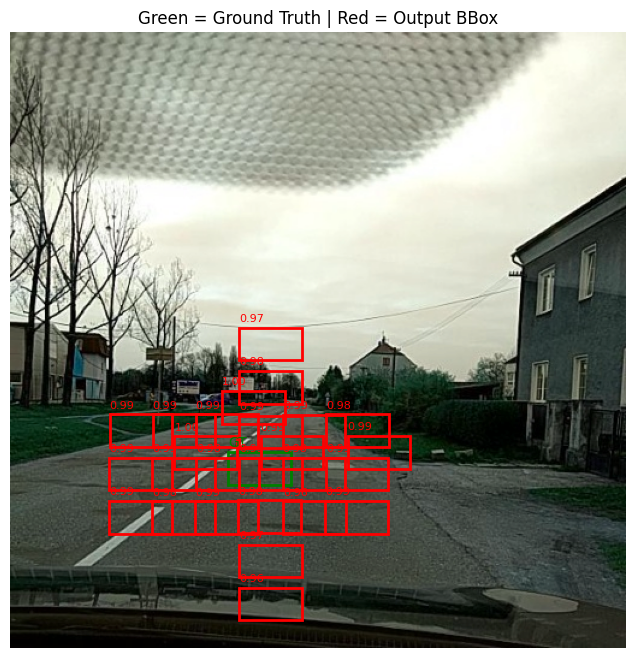

In [65]:
# Load the exact sample the model was trained on
positive_image, positive_gt_boxes, _ = training_dataset[1]
positive_image = positive_image.unsqueeze(0).to(device)  # Add batch dim

# Run inference using your overfit model
positive_pred_boxes, positive_pred_scores = run_inference(
    positive_sanity_model,
    positive_image,
    anchors,
    device,
    conf_thresh=0.95,  # You can play with this
    nms_thresh=0.5
)

def denormalize(img_tensor):
  mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
  std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
  return (img_tensor * std + mean).clamp(0, 1)

positive_image_denorm = denormalize(positive_image.squeeze(0).cpu())

# Visualize predictions vs GT
visualize_prediction(
    positive_image_denorm,
    positive_gt_boxes.cpu(),
    positive_pred_boxes.cpu(),
    positive_pred_scores.cpu()
)


In [43]:
print("GT Boxes:", positive_gt_boxes)


GT Boxes: tensor([[181., 349., 233., 376.]])


## Sanity Check: 50 Samples

Currently the mAP@50 is 0.000, and the model can't overfit!

In [71]:
backbone_50 = MobileNetBackbone()
detection_heads_50 = nn.ModuleList([
    DetectionHead(24, num_anchors_per_location, 1),    # for fmap1
    DetectionHead(32, num_anchors_per_location, 1),   # for fmap2
    DetectionHead(1280, num_anchors_per_location, 1)   # for fmap3
])
sample_loader_50 = DataLoader(Subset(training_dataset, range(50)),
                              batch_size=4, shuffle=False,
                              collate_fn=collate_fn)
model_50 = SSD(backbone, detection_heads_50)
train_model(model_50, sample_loader_50, anchors, device, num_epochs=50, lr=2e-3)

[Epoch 1] Cls Loss: 238.8667, Loc Loss: 10.8258
[Epoch 2] Cls Loss: 146.8030, Loc Loss: 9.6905
[Epoch 3] Cls Loss: 109.0959, Loc Loss: 8.8001
[Epoch 4] Cls Loss: 78.4150, Loc Loss: 7.3958
[Epoch 5] Cls Loss: 67.7630, Loc Loss: 6.9400
[Epoch 6] Cls Loss: 54.1542, Loc Loss: 6.4616
[Epoch 7] Cls Loss: 47.1283, Loc Loss: 6.2862
[Epoch 8] Cls Loss: 41.9144, Loc Loss: 5.7169
[Epoch 9] Cls Loss: 38.2086, Loc Loss: 5.3850
[Epoch 10] Cls Loss: 34.9962, Loc Loss: 4.8427
[Epoch 11] Cls Loss: 31.9512, Loc Loss: 4.7120
[Epoch 12] Cls Loss: 29.2684, Loc Loss: 4.5126
[Epoch 13] Cls Loss: 26.7960, Loc Loss: 4.2660
[Epoch 14] Cls Loss: 24.4645, Loc Loss: 4.1549
[Epoch 15] Cls Loss: 22.3737, Loc Loss: 4.0123
[Epoch 16] Cls Loss: 20.6796, Loc Loss: 3.8625
[Epoch 17] Cls Loss: 19.3301, Loc Loss: 3.7261
[Epoch 18] Cls Loss: 18.0340, Loc Loss: 3.6076
[Epoch 19] Cls Loss: 17.0114, Loc Loss: 3.4746
[Epoch 20] Cls Loss: 16.0978, Loc Loss: 3.3513
[Epoch 21] Cls Loss: 15.5075, Loc Loss: 3.2386
[Epoch 22] Cls Los

In [83]:
evaluate_ssd_map(model_50, sample_loader_50, anchors, device, conf_thresh=0.3)


Output hidden; open in https://colab.research.google.com to view.

## Underfitting Present

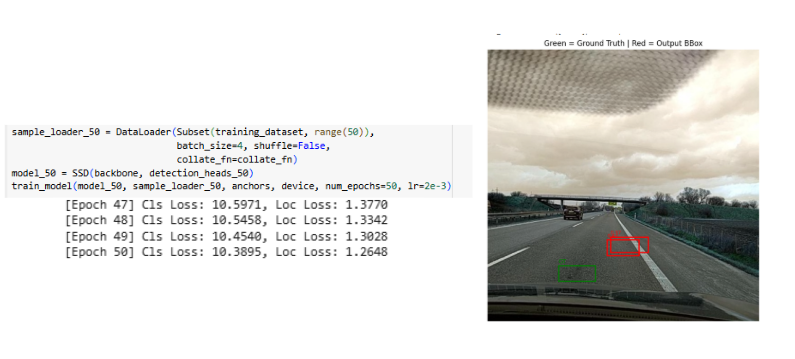


